<a href="https://colab.research.google.com/github/NanaAkwasiAbayieBoateng/NLP/blob/main/English_Twi_Neural_Machine_Translation_with_attention_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Translation (MT)
is the task of translating a sentence x
from one language (the source language ) to a sentence y in
another language (the target language).
Neural Machine Tranlaston(NMT) is a branch of natural language processing that uses deep learning models to predict the likelihood of a sequence of words in translating one language to the other. The development of some alogrithms such as Seq2Seq, Attention, Transformers etc has revolutuonalized the ability of machine learning models to translate text at a very good performance. NMT models represent words as embeddings(numeric vector representation).


The  NMT network architecture called  sequence to sequence
(seq2seq )  consist of  two RNNs namely the encoder and decoder networks. The encoder is a bidirectional RNN used to encode a source sentence into a fixed-length vector for a second RNN known as the decoder. The decoder is used to predict words in the target language conditioned on the encoding. The encoder–decoder system is  trained to maximize the probability of a correct translation given a source sentence.
A draw-back of the encoder-decoder architecture is encoding long inputs into a single vector. 
 The Attention mechanism alleviates  the difficulties faced by RNNs in encoding long inputs into a single vector. The Attention mechanism  allows the decoder to focus on different parts of the input while generating each word of the output.







The draw-back of using the enoder-decoder architechture comes  from the fixed-length internal representation that must be used to decode each word in the output sequence.

The solution is the use of an attention mechanism that allows the model to learn where to place attention on the input sequence as each word of the output sequence is decoded.

Using a fixed-sized representation to capture all the semantic details of a very long sentence  is very difficult. A more efficient approach to capture all the semantic details of a very long sentence is to read the whole sentence or paragraph , then to produce the translated words one at a time, each time focusing on a different part of the input sentence to gather the semantic details required to produce the next output word. Part of the code used here was adapted from the tensorflow website [here](https://www.tensorflow.org/tutorials/text/nmt_with_attention)





In [ ]:
#!pip install tensorflow==2.2

In [ ]:
#specify tensorflow version to use
#%tensorflow_version 2.x
#load tensorboard
#%load_ext tensorboard
 #%tensorboard --logdir logs
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import pandas as pd
import os
import io
import time
# encoding=utf8
from importlib import reload
import sys
reload(sys)
import tensorflow_addons as tfa
print("Tensorflow version {}".format(tf.__version__))
print("Tensorflow addon version {}".format(tfa.__version__))
#sys.setdefaultencoding('utf8')
%autosave 5
#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#session = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction)
#from tf.keras.layers.experimental.preprocessing import TextVectorization

Tensorflow version 2.3.0
Tensorflow addon version 0.8.3


Autosaving every 5 seconds


In [ ]:
#drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The parallel English to Twi JW300 dataset  can be  downloaded here [here](http://opus.nlpl.eu/JW300.php).JW300 is a parallel corpus of over 300 languages with around 100 thousand parallel sentences per language pair on average.

In [ ]:
#If you want to use the file and not have to remember to close it afterward, do this:


with open('/content/drive/My Drive/Data/jw300.en-tw.tw', 'r') as f:
     #Twi_data = f.readlines()
      Twi_data= f.read().splitlines()

In [ ]:
Twi_data[0:5] 

['“ Oo , Yehowa , Boa Me Babea Kumaa Yi Ma Onni Nokware ! ”',
 'WƆWOO me too abusua a wonim adwinne di mu wɔ Alsace , France , wɔ 1930 mu .',
 'Ná Papa taa pa twere n’agua mu kenkan asase ho nsɛm anaa ewim nneɛma ho nhoma bi anwummere anwummere .',
 'Ná me kraman da Papa nan so , na na ɔka nsɛntitiriw a epue wɔ n’akenkan no mu kyerɛ Maame bere a ɔnwene abusua no nneɛma no .',
 'Ná m’ani gye anwummere a ɛtete saa no ho kɛse !']

In [ ]:
english_data = [line.rstrip() for line in open('/content/drive/My Drive/Data/jw300.en-tw.en')]
english_data[0:5]

['“ Oh , Jehovah , Keep My Young Girl Faithful ! ”',
 'I WAS born in 1930 in Alsace , France , into an artistic family .',
 'During the evenings , Father , sitting in his lounge chair , would be reading some books about geography or astronomy .',
 'My doggy would be sleeping by his feet , and Daddy would be sharing with Mum some highlights from his reading while she was knitting for her family .',
 'How much I enjoyed those evenings !']

In [ ]:
num_examples=10000
print(len(english_data))
print(len(Twi_data))

606197
606197


#### sequence to sequence
A Gated Reccurrent Unit(GRU) encoder decoder model with attention mechanism will used for the translation task in this article. First, we will preprocess the data by  cleaning up the data thus  removing unwanted characters. Append $<start>$ and $<end>$ to the beginning and end of line of text. Adding  $<start>$ and an $<end>$ token to the sentence lets the model know  when to start and stop predicting.  Afterwards create  a word index and reverse word index then pad each sentence to a maximum length.

In [ ]:
def normalize_eng(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def normalize_twi(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.ƆɔɛƐ!?’]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s


# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence_english(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  #w = re.sub(r'[^Ɔ-ɔɛƐ]+', r' ', w)
  #strip() Parameters
  #chars (optional) - a string specifying the set of characters to be removed.
  #If the chars argument is not provided, all leading and trailing whitespaces are removed from the string.
  w = w.rstrip().strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w




  
def preprocess_sentence_twi(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-ZɛƐɔƆ?.!,¿]+", " ", w)
  #w = re.sub(r'[^Ɔ-ɔɛƐ]+', r' ', w)
  #strip() Parameters
  #chars (optional) - a string specifying the set of characters to be removed.
  #If the chars argument is not provided, all leading and trailing whitespaces are removed from the string.
  w = w.rstrip().strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
#type(english_data)

english_d  = list(map(preprocess_sentence_english,english_data))
english_d[0:5]

['<start> oh , jehovah , keep my young girl faithful ! <end>',
 '<start> i was born in in alsace , france , into an artistic family . <end>',
 '<start> during the evenings , father , sitting in his lounge chair , would be reading some books about geography or astronomy . <end>',
 '<start> my doggy would be sleeping by his feet , and daddy would be sharing with mum some highlights from his reading while she was knitting for her family . <end>',
 '<start> how much i enjoyed those evenings ! <end>']

In [ ]:
twi_d  = list(map(preprocess_sentence_twi,Twi_data))
twi_d[0:5]

['<start> oo , yehowa , boa me babea kumaa yi ma onni nokware ! <end>',
 '<start> wɔwoo me too abusua a wonim adwinne di mu wɔ alsace , france , wɔ mu . <end>',
 '<start> na papa taa pa twere n agua mu kenkan asase ho nsɛm anaa ewim nneɛma ho nhoma bi anwummere anwummere . <end>',
 '<start> na me kraman da papa nan so , na na ɔka nsɛntitiriw a epue wɔ n akenkan no mu kyerɛ maame bere a ɔnwene abusua no nneɛma no . <end>',
 '<start> na m ani gye anwummere a ɛtete saa no ho kɛse ! <end>']

To speed up the training time and reduce memory and computation time, I will limit the data to sentence pairs with maximum length less than 40 and select about 10000 pairs of the resulting data for training.This will reduce the performance of the model, if you have access to more compuational resources you can train on a lot more  dataset which would greatly improve the model performance.

In [ ]:
# reduce the data to lines with length <= 40
max_length = 40
seq_length= [len(word) for word in english_d]
d= pd.DataFrame({"English":english_d,"Twi":twi_d,"seq_length":seq_length}).query('seq_length <= 40 and seq_length > 17')
d.head(10)

,English,Twi,seq_length
12,<start> dad was upset about that . <end>,<start> eyi haw me papa . <end>,40
14,<start> no reading of that stuff ! <end>,<start> monnkenkan saa nhoma a mfaso biara nni...,40
24,<start> that was in . <end>,<start> na eyi yɛ . <end>,27
44,<start> persecution at school <end>,<start> sukuu ɔtae <end>,35
69,<start> underground activity <end>,<start> esum ase adwumayɛ <end>,34
107,<start> i was put in the middle . <end>,<start> wɔde me kogyinaa mfinimfini . <end>,39
117,<start> never be obstinate . <end>,<start> nsene wo kɔn da . <end>,34
124,<start> you are a young lady now . <end>,<start> woyɛ ababaa mprempren . <end>,40
141,<start> i began to cry again . <end>,<start> mifii ase sui bio . <end>,36
161,<start> there was no playtime . <end>,<start> na yenni bere a yɛde di agoru . <end>,37


In [ ]:
d.tail()

,English,Twi,seq_length
606124,<start> pride . <end>,<start> ahantan . <end>,21
606161,<start> see opening picture . <end>,<start> hwɛ mfonini a ɛwɔ adesua yi mfiase no ...,35
606165,<start> read daniel . <end>,<start> kenkan daniel . <end>,27
606169,<start> he said take courage ! <end>,<start> ɔkae sɛ momma mo bo ntɔ mo yam ! <end>,36
606183,<start> ask them to pray for you . <end>,<start> ka kyerɛ wɔn sɛ wɔmmɔ mpae mma wo . <end>,40


In [ ]:
d1 = d.iloc[:10000,0:2]
English_d = d1.English.tolist()
Twi_d  = d1.Twi.tolist()
print('shape of data {}'.format(d1.shape))

shape of data (10000, 2)


The create_dataset_eng  and create_dataset_twi are used in preprocessing the english and twi dataset respectively. There is special characters in the twi dataset that need to be preserved, using the same preprocessing function for both languages will remove such characters.

In [ ]:
def create_dataset_eng(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence_english(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
#encoding = ‘utf-8-sig’ is added to overcome the issue when exporting ‘Non-English’ languages.
def create_dataset_twi(path, num_examples):
  lines = io.open(path, encoding='utf-8-sig').read().strip().split('\n')

  word_pairs = [[preprocess_sentence_twi(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_data( num_examples=None):
  # creating cleaned input, output pairs
  targ_lang  = English_d[0:num_examples]
  inp_lang =   Twi_d[0:num_examples]

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 10000
input_tensor, target_tensor, inp_lang, targ_lang = load_data( num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
print(max_length_targ)
print(max_length_inp)

12
46


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

8000 8000 2000 2000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
5 ----> kratafa
8 ----> mfonini
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
9 ----> picture
6 ----> on
5 ----> page
2 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
print(BUFFER_SIZE)
print(steps_per_epoch)
print(vocab_inp_size)
print(vocab_tar_size)

8000
125
4465
5273


#### Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [ ]:
#dataset_ds = dataset.cache().prefetch(buffer_size=BUFFER_SIZE)
dataset_ds = dataset.cache().prefetch(buffer_size=BUFFER_SIZE)
#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=)
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

#train_ds = train_ds.cache().prefetch(buffer_size=32)
#val_ds = val_ds.prefetch(buffer_size=32)

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 46]), TensorShape([64, 12]))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 46, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 46, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5273)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 29


for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9905
Epoch 1 Batch 100 Loss 1.7621
Epoch 1 Loss 1.8875
Time taken for 1 epoch 719.2212615013123 sec

Epoch 2 Batch 0 Loss 1.7736
Epoch 2 Batch 100 Loss 1.3239
Epoch 2 Loss 1.5190
Time taken for 1 epoch 724.0574946403503 sec

Epoch 3 Batch 0 Loss 1.1104
Epoch 3 Batch 100 Loss 1.3764
Epoch 3 Loss 1.3078
Time taken for 1 epoch 726.3984086513519 sec

Epoch 4 Batch 0 Loss 1.0803
Epoch 4 Batch 100 Loss 0.9809
Epoch 4 Loss 1.1435
Time taken for 1 epoch 728.3927986621857 sec

Epoch 5 Batch 0 Loss 0.8860
Epoch 5 Batch 100 Loss 1.1375
Epoch 5 Loss 1.0040
Time taken for 1 epoch 733.5616323947906 sec

Epoch 6 Batch 0 Loss 0.9482
Epoch 6 Batch 100 Loss 0.7983
Epoch 6 Loss 0.8748
Time taken for 1 epoch 728.564147233963 sec

Epoch 7 Batch 0 Loss 0.6199
Epoch 7 Batch 100 Loss 0.7140
Epoch 7 Loss 0.7506
Time taken for 1 epoch 726.8015584945679 sec

Epoch 8 Batch 0 Loss 0.6675
Epoch 8 Batch 100 Loss 0.7154
Epoch 8 Loss 0.6333
Time taken for 1 epoch 727.0260283946991 sec

Epoch 9 B

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence_twi(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
#Twi_data[0:5] #
#d.shape
d.iloc[20000,0]
re.sub(r"<start> | <end>", r" ", d.iloc[20000,1])

' will there be survivors ? '

In [ ]:
def translate(sentence,actual):
  result, sentence, attention_plot = evaluate(sentence)
   
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  print('Actual translation: {}'.format(actual))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
!ls '/content/drive/My Drive'

'Colab Notebooks'	       ImbalancedData
 cp.ckpt.data-00000-of-00001   NaturalLanguageProcessing
 Data			       Photos.zip
 documents		       pictures
 foo.txt		       profilingReport2.html
'GE (1).csv'		      'Sample upload.txt'
 GE.csv			      'To-do list.gsheet'
'Getting started.pdf'


In [ ]:
#manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

#train_and_checkpoint(net, manager)

 will there be survivors ? 
Input: <start> eyi haw me papa . <end>
Predicted translation: heritage thrown else prayer silent sacrifice watch scientists copy commendation flirting headgear 
Actual translation:  will there be survivors ? 


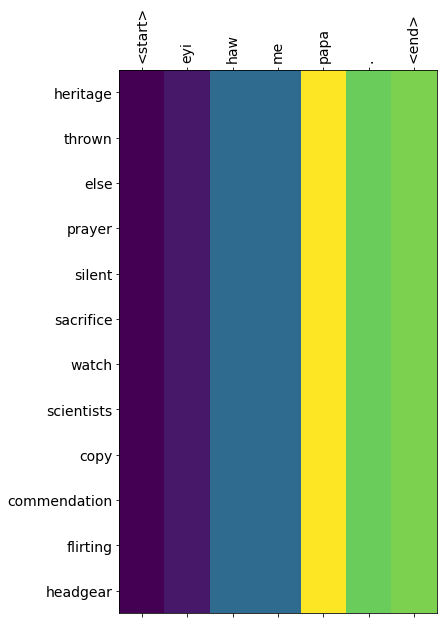

In [ ]:
actual = re.sub(r"<start> | <end>", r" ", d.iloc[20000,0])
print(re.sub(r"<start> | <end>", r" ", d.iloc[20000,0]))
translate(u' eyi haw me papa . ',actual)

Input: <start> ɔkae sɛ momma mo bo ntɔ mo yam ! <end>
Predicted translation: molecule fired reunited animal begins nests grandma molecule fired reunited animal begins 


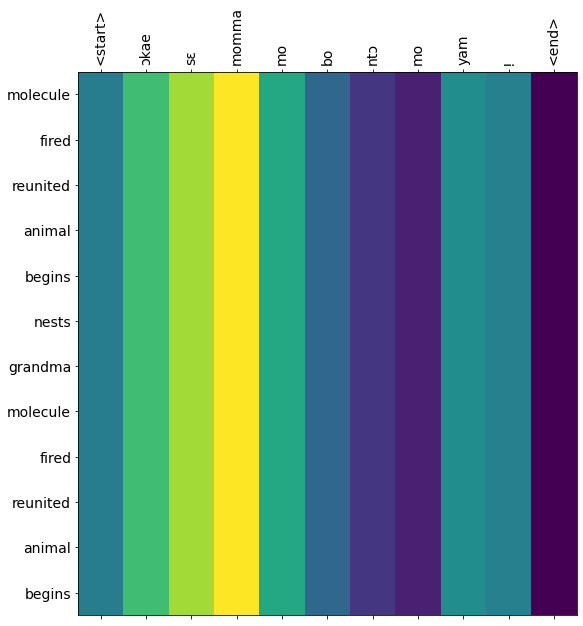

Input: <start> eyi haw me papa . <end>
Predicted translation: molecule fired reunited animal begins nests ball bathtub marathon fired reunited animal 


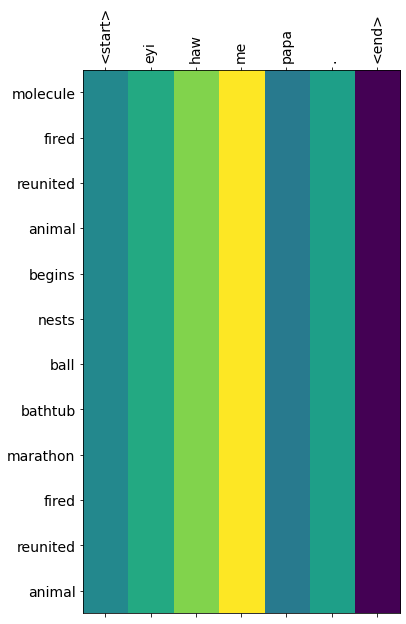

In [ ]:
translate(u' ɔkae sɛ momma mo bo ntɔ mo yam ! ')
translate(u' eyi haw me papa . ')